# Baichuan-13B 保姆级微调范例

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

干货预警：这可能是你能够找到的最容易懂的，最完整的，适用于各种NLP任务的Baichuan-13B-Chat的finetune教程~

Baichuan-13B是百川智能于2023年7月11日发布的开源中英双语LLM，各项指标经评测在开源LLM中同尺寸模型中位居前列。

Baichuan-13B包括Baichuan-13B-Base和Baichuan-13B-chat两个不同模型。前者仅仅是预训练模型，后者在前者基础上增加了SFT,RLHF等偏好对齐过程。

本范例微调的模型是Baichuan-13B-Chat，我们使用非常简单的，外卖评论数据集来实施微调，对一段外卖评论区分是好评还是差评。

可以发现，经过微调后的模型，相比直接 3-shot-prompt 可以取得明显更好的效果(0.89->0.90)。

虽然Baichuan-13B-Chat是一个百亿级的LLM，但由于我们使用非常节约显存的QLoRA微调算法，具备32G左右显存的GPU即可实施本过程。

值得注意的是，尽管我们以文本分类任务为例，实际上，任何NLP任务，例如，命名实体识别，翻译，聊天对话等等，都可以通过加上合适的上下文，转换成一个对话问题，并针对我们的使用场景，设计出合适的数据集来微调Baichuan-13B-Chat.


注，本教程是 ChatGLM2-6b保姆级微调范例 的兄弟版本~


In [11]:
#安装环境

# #baichuan-13b-chat
# !pip install 'transformers==4.30.2'
# !pip install  -U transformers_stream_generator
# 
# 
# #finetune
# !pip install datasets
# !pip install git+https://github.com/huggingface/accelerate
# !pip install  git+https://github.com/huggingface/peft
# !pip install  git+https://github.com/lyhue1991/torchkeras 
!pip install 'bitsandbytes' #4bit量化

Found existing installation: bitsandbytes 0.39.1
Uninstalling bitsandbytes-0.39.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/bitsandbytes-0.39.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/bitsandbytes/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [1]:
!du -s -h ~/Projects/MLE/models/Baichuan2-7B-Chat

29G	/home/zhongbing/Projects/MLE/models/Baichuan2-7B-Chat


## 〇，预训练模型

我们需要从 https://huggingface.co/baichuan-inc/Baichuan-13B-Chat 下载baichuan-13b-chat的模型。

国内可能速度会比较慢，总共有25个G左右，网速不太好的话，大概可能需要两到三个小时。

如果网络不稳定，也可以手动从这个页面一个一个下载全部文件然后放置到 一个文件夹中例如 'baichuan-13b' 以便读取。


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn


#使用QLoRA引入的 NF4量化数据类型以节约显存
model_name_or_path ='/home/zhongbing/Projects/MLE/models/Baichuan2-7B-Chat' #远程 'baichuan-inc/Baichuan-13B-Chat'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
from IPython.display import clear_output 
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是哪座?"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)
    
    

世界上第二高的山峰是喜马拉雅山脉的珠穆朗玛峰（Mount Everest），海拔高度为8,848米（29,031英尺）。


下面我们设计一个3-shot-prompt方法，使用外卖数据集测试一下BaiChuan13b的文本分类能力。

In [6]:
prefix = """你是一个要素提取专家，你需要从输入文本中提取购汇或结汇信息,其中购汇是买入外汇，结汇是卖出外汇。如果遍历输入文本没有明确提到购汇或结汇，则返回nan。
下面是一些范例，案例无需处理:

```
输入：明天美元购汇
输出：购汇

输入：欧元结汇
输出：结汇

输入：欧元购汇
输出：购汇

输入：卖美元买美元
输出：nan
```

以下为一个真实输入，只需输出结汇、购汇或nan，不要添加任何其他无关内容：
"""

def get_prompt(text):
    return prefix+text+'\n输出：'


In [7]:
messages  = [{"role": "user", "content": get_prompt('买入美元卖出人民币')}]
response = model.chat(tokenizer, messages)
print(response)
messages

结汇


[{'role': 'user',
  'content': '你是一个要素提取专家，你需要从输入文本中提取购汇或结汇信息,其中购汇是买入外汇，结汇是卖出外汇。如果遍历输入文本没有明确提到购汇或结汇，则返回nan。\n下面是一些范例，案例无需处理:\n\n```\n输入：明天美元购汇\n输出：购汇\n\n输入：欧元结汇\n输出：结汇\n\n输入：欧元购汇\n输出：购汇\n\n输入：卖美元买美元\n输出：nan\n```\n\n以下为一个真实输入，只需输出结汇、购汇或nan，不要添加任何其他无关内容：\n买入美元卖出人民币\n输出：'}]

In [8]:
messages = messages+[{"role": "assistant", "content": response}]
print(messages)


[{'role': 'user', 'content': '你是一个要素提取专家，你需要从输入文本中提取购汇或结汇信息,其中购汇是买入外汇，结汇是卖出外汇。如果遍历输入文本没有明确提到购汇或结汇，则返回nan。\n下面是一些范例，案例无需处理:\n\n```\n输入：明天美元购汇\n输出：购汇\n\n输入：欧元结汇\n输出：结汇\n\n输入：欧元购汇\n输出：购汇\n\n输入：卖美元买美元\n输出：nan\n```\n\n以下为一个真实输入，只需输出结汇、购汇或nan，不要添加任何其他无关内容：\n买入美元卖出人民币\n输出：'}, {'role': 'assistant', 'content': '结汇'}]


In [10]:
def get_message(prompt,response):
    return [{"role": "user", "content": f'{prompt} -> '},
            {"role": "assistant", "content": response}]

In [11]:
messages.extend(get_message('20230909购汇欧元','购汇'))
messages.extend(get_message('非日元结汇','结汇'))
messages.extend(get_message('这么咸，真的是醉了','nan'))

In [12]:
messages 

[{'role': 'user',
  'content': '你是一个要素提取专家，你需要从输入文本中提取购汇或结汇信息,其中购汇是买入外汇，结汇是卖出外汇。如果遍历输入文本没有明确提到购汇或结汇，则返回nan。\n下面是一些范例，案例无需处理:\n\n```\n输入：明天美元购汇\n输出：购汇\n\n输入：欧元结汇\n输出：结汇\n\n输入：欧元购汇\n输出：购汇\n\n输入：卖美元买美元\n输出：nan\n```\n\n以下为一个真实输入，只需输出结汇、购汇或nan，不要添加任何其他无关内容：\n买入美元卖出人民币\n输出：'},
 {'role': 'assistant', 'content': '结汇'},
 {'role': 'user', 'content': '20230909购汇欧元 -> '},
 {'role': 'assistant', 'content': '购汇'},
 {'role': 'user', 'content': '非日元结汇 -> '},
 {'role': 'assistant', 'content': '结汇'},
 {'role': 'user', 'content': '这么咸，真的是醉了 -> '},
 {'role': 'assistant', 'content': 'nan'}]

In [13]:
def predict(text,temperature=0.01):
    model.generation_config.temperature=temperature
    response = model.chat(tokenizer, 
                          messages = messages+[{'role':'user','content':f'{text} -> '}])
    return response


In [14]:
predict('我想卖下个月的美元') #惊喜，居然预测对了

'购汇'

我们拿外卖数据集来测试一下未经微调，预训练模型的效果。

In [30]:
import pandas as pd 
import numpy as np 
import datasets 
from tqdm import tqdm 

#数据集分割
df = pd.read_csv("./ZXC_Forward_Tuning_Cases.csv")

# replace all except '购汇' and '结汇' with 'nan' in a df
df['tag'] = df['购汇结汇'].apply(lambda x: x if x in ['购汇','结汇'] else 'nan')

# calculate the number of all candidate for tag
df['tag'].value_counts()

# df = df.rename({'review':'text'},axis = 1)
# 
# dfgood = df.query('tag=="好评"')
# dfbad = df.query('tag=="差评"').head(len(dfgood)) #采样部分差评，让好评差评平衡
# df = pd.concat([dfgood,dfbad])
# 
ds_dic = datasets.Dataset.from_pandas(df).train_test_split(
    test_size = 10,shuffle=True, seed = 43)
dftrain = ds_dic['train'].to_pandas()
dftest = ds_dic['test'].to_pandas()
dftrain.to_parquet('./data/dftrain.parquet')
dftest.to_parquet('./data/dftest.parquet')

In [31]:
#数据集加载
dftrain = pd.read_parquet('./data/dftrain.parquet')[['INPUT','购汇结汇','tag']]
dftest = pd.read_parquet('./data/dftest.parquet')[['INPUT','购汇结汇','tag']]
ds_train,ds_val = datasets.Dataset.from_pandas(dftrain).train_test_split(
    test_size=10,seed=42).values()\

dftrain,dfval = ds_train.to_pandas(), ds_val.to_pandas() 

In [32]:
dftest['pred'] = [predict(text) for text in tqdm(dftest['INPUT'])]

100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


In [35]:
dftest.query('tag==pred').shape  
dftest

,INPUT,购汇结汇,tag,pred
0,EURCNY 20221111 结汇,结汇,结汇,结汇
1,@招小萃 sell usdcny 3m,None,nan,结汇
2,即期结汇,结汇,结汇,结汇
3,.USDCNH T+0 结汇,结汇,结汇,结汇
4,USDCNH 20231215,None,nan,购汇
5,SELL EURCNY T+0,None,nan,结汇
6,Sell USDCNY 后天,None,nan,结汇
7,USDeur 20231016 购汇,购汇,购汇,购汇
8,今日美元兑人民币价格,None,nan,nan
9,远期美元购汇20230710,购汇,购汇,购汇


In [36]:
print('acc = ',len(dftest.query('tag==pred'))/len(dftest))   

acc =  0.6


In [40]:
dftest.pivot_table(index='pred',columns = 'tag',
                   values='INPUT',aggfunc='count')


tag,nan,结汇,购汇
pred,,,
nan,1.0,NaN,NaN
结汇,3.0,3.0,NaN
购汇,1.0,NaN,2.0


## 一，准备数据

我们仿照百川模型的 `model._build_chat_input` 方法来进行token编码，同时把需要学习的内容添加label.

### 1，token编码

In [41]:
import torch 

#将messages编码成 token, 同时返回labels, 该函数适用于多轮对话数据
#注意baichuan-13b通过插入tokenizer.user_token_id和tokenizer.assistant_token_id 来区分用户和机器人会话内容

# reference@ model._build_chat_input?
def build_chat_input(messages, model=model,
                     tokenizer=tokenizer, 
                     max_new_tokens: int=0):
    max_new_tokens = max_new_tokens or model.generation_config.max_new_tokens
    max_input_tokens = model.config.model_max_length - max_new_tokens
    max_input_tokens = max(model.config.model_max_length // 2, max_input_tokens)
    
    total_input, round_input, total_label, round_label = [], [], [], []
    
    for i, message in enumerate(messages[::-1]):
        content_tokens = tokenizer.encode(message['content'])
        if message['role'] == 'user':
            round_input = [model.generation_config.user_token_id] + content_tokens + round_input
            round_label = [-100]+[-100 for _ in content_tokens]+ round_label
            
            if total_input and len(total_input) + len(round_input) > max_input_tokens:
                break
            else:
                total_input = round_input + total_input
                total_label = round_label + total_label
                if len(total_input) >= max_input_tokens:
                    break
                else:
                    round_input = []
                    round_label = []
                    
        elif message['role'] == 'assistant':
            round_input = [
                model.generation_config.assistant_token_id
            ] + content_tokens + [
                model.generation_config.eos_token_id
            ] + round_input

            round_label = [
                -100
            ] + content_tokens + [
                model.generation_config.eos_token_id
            ]+ round_label
        else:
            raise ValueError(f"message role not supported yet: {message['role']}")
            
    total_input = total_input[-max_input_tokens:]  # truncate left
    total_label = total_label[-max_input_tokens:]
    
    total_input.append(model.generation_config.assistant_token_id)
    total_label.append(-100)
    
    return total_input,total_label


### 2，做数据集

In [46]:
from torch.utils.data import Dataset,DataLoader 
class MyDataset(Dataset):
    def __init__(self,df,
                 prefix=prefix
                ):
        self.df = df 
        self.prefix=prefix
        
    def __len__(self):
        return len(self.df)
        
    def get_samples(self,index):
        samples = []
        d = dict(self.df.iloc[index])
        samples.append(d)
        return samples
    
    def get_messages(self,index):
        samples = self.get_samples(index)
        messages = []
        for i,d in enumerate(samples):
            if i==0:
                messages.append({'role':'user','content':self.prefix+d['INPUT']+' -> '})
            else:
                messages.append({'role':'user','content':d['INPUT']+' -> '})
            
            messages.append({'role':'assistant','content':d['tag']})
        return messages
        
    def __getitem__(self,index):
        messages = self.get_messages(index)
        input_ids, labels = build_chat_input(messages)
        return {'input_ids':input_ids,'labels':labels}

    def show_sample(self,index):
        samples = self.get_samples(index)
        print(samples)
    
    

In [47]:
ds_train = MyDataset(dftrain)
ds_val = MyDataset(dfval)


In [48]:
ds_train.show_sample(0)

[{'INPUT': 'Sell USDCNY 5M', '购汇结汇': None, 'tag': 'nan'}]


In [49]:
print(ds_train[0]) 

{'input_ids': [195, 26553, 13813, 11536, 3226, 65, 24450, 92569, 4762, 24734, 87639, 92974, 93362, 92600, 92646, 93362, 1833, 92323, 2410, 92974, 93362, 92347, 26549, 32405, 65, 92646, 93362, 92347, 27482, 32405, 66, 1786, 93710, 92846, 4762, 24734, 1667, 3618, 10747, 92974, 93362, 92600, 92646, 93362, 65, 92948, 10078, 19281, 66, 5, 43707, 2204, 84529, 65, 5169, 9426, 2639, 92345, 5, 5, 84, 5, 4762, 70, 7413, 5673, 92974, 93362, 5, 12785, 70, 92974, 93362, 5, 5, 4762, 70, 32574, 92646, 93362, 5, 12785, 70, 92646, 93362, 5, 5, 4762, 70, 32574, 92974, 93362, 5, 12785, 70, 92974, 93362, 5, 5, 4762, 70, 93296, 5673, 92932, 5673, 5, 12785, 70, 19281, 5, 84, 5, 5, 41639, 1558, 4139, 4762, 65, 11065, 12785, 92646, 93362, 69, 92974, 93362, 92600, 19281, 65, 2173, 4193, 2834, 2185, 12889, 2079, 70, 5, 92340, 1547, 2684, 8741, 13765, 92311, 92358, 92353, 92311, 63, 92574, 92311, 196, 19281, 2, 196], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -

### 3，创建管道

In [50]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [51]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)

dl_val = torch.utils.data.DataLoader(ds_val,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=False,
                                     collate_fn = data_collator)


In [52]:
for batch in dl_train:
    break 

In [53]:
#试跑一个batch
out = model(**batch)

In [54]:
out.loss 

tensor(2.4941, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

In [55]:
len(dl_train)

8

In [56]:
#采样300个batch作为一个epoch，便于较快验证
dl_train.size = 300

## 二，定义模型

下面我们将使用QLoRA(实际上用的是量化的AdaLoRA）算法来微调Baichuan-13b模型。

In [57]:
from peft import get_peft_config, get_peft_model, TaskType
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [58]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


In [59]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)


In [69]:
lora_modules = find_all_linear_names(model)
print(lora_modules) 


['up_proj', 'down_proj', 'gate_proj', 'W_pack', 'o_proj']


In [70]:
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=64,
    lora_alpha=16, lora_dropout=0.05,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()


trainable params: 26,838,912 || all params: 7,532,812,320 || trainable%: 0.35629338499170254


In [71]:
out = peft_model.forward(**batch)

AttributeError: 'Parameter' object has no attribute 'weight'

In [65]:
out[0]

tensor(2.4941, dtype=torch.float16, grad_fn=<ToCopyBackward0>)

## 三，训练模型

In [66]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net.forward(**batch)[0]

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 

#仅仅保存QLora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [67]:
optimizer = bnb.optim.adamw.AdamW(peft_model.parameters(),
                                  lr=6e-05,is_paged=True)  #'paged_adamw'
keras_model = KerasModel(peft_model,loss_fn =None,
        optimizer=optimizer) 
ckpt_path = 'baichuan13b_waimai'



<<<<<< ⚡️ cuda is used >>>>>>


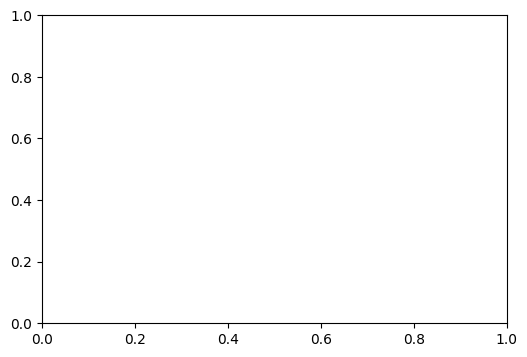

AttributeError: 'Parameter' object has no attribute 'weight'

In [68]:
# keras_model.load_ckpt(ckpt_path) #支持加载微调后的权重继续训练(断点续训)
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=10,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path
               )


## 四，保存模型

为减少GPU压力，此处可重启kernel释放显存

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn
model_name_or_path ='../baichuan-13b'
ckpt_path = 'baichuan13b_waimai'
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    trust_remote_code=True
)
model_old = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map='auto'
)


[2023-07-19 23:21:49,363] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from peft import PeftModel

#可能需要5分钟左右
peft_model = PeftModel.from_pretrained(model_old, ckpt_path)
model_new = peft_model.merge_and_unload()



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /usr/local/lib/python3.8/dist-packages/bitsandbytes/libbitsandbytes_cuda116.so...


In [4]:
from transformers.generation.utils import GenerationConfig
model_new.generation_config = GenerationConfig.from_pretrained(model_name_or_path)

In [5]:
from IPython.display import clear_output
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是什么？"})
response = model_new.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

乔戈里峰。世界第二高峰———乔戈里峰西方登山者称其为k2峰，海拔高度是8611米，位于喀喇昆仑山脉的中巴边境上


In [6]:
save_path = 'baichuan-13b-waimai'

In [7]:
tokenizer.save_pretrained(save_path)
model_new.save_pretrained(save_path)

In [8]:
!cp ../baichuan-13b/*.py  baichuan-13b-waimai

## 五，使用模型

为减少GPU压力，此处可再次重启kernel释放显存。

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

model_name_or_path = 'baichuan-13b-waimai'

bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

tokenizer = AutoTokenizer.from_pretrained(
   model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

model.generation_config = GenerationConfig.from_pretrained(model_name_or_path)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
from IPython.display import clear_output
messages = []
messages.append({"role": "user",
                 "content": "世界上第二高的山峰是什么？"})
response = model.chat(tokenizer,messages=messages,stream=True)
for res in response:
    print(res)
    clear_output(wait=True)

乔戈里峰。世界第二高峰———乔戈里峰
海拔高度：8610米
坐标纬度：35°49′15′′n,76°21′24′′e
地理位置：喀喇昆仑山脉中巴边境上


我们测试一下微调后的效果。

In [12]:
import pandas as pd 
import numpy as np 
import datasets 
from tqdm import tqdm 


In [15]:
prefix = """外卖评论文本分类任务:
下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评

请对下述评论进行分类。返回'好评'或者'差评'。
"""

def get_prompt(text):
    return prefix+text+' -> '


In [18]:
messages  = [{"role": "user", "content": get_prompt('味道不错，下次再来')}]
response = model.chat(tokenizer, messages)
print(response)


好评


In [19]:
messages = messages+[{"role": "assistant", "content": response}]
print(messages)

[{'role': 'user', 'content': "外卖评论文本分类任务:\n下面是一些范例:\n\n味道真不错 -> 好评\n太辣了，吃不下都  -> 差评\n\n请对下述评论进行分类。返回'好评'或者'差评'。\n味道不错，下次再来 -> "}, {'role': 'assistant', 'content': '好评'}]


In [20]:
def get_message(prompt,response):
    return [{"role": "user", "content": f'{prompt} -> '},
            {"role": "assistant", "content": response}]

In [21]:
messages.extend(get_message('太贵了','差评'))
messages.extend(get_message('非常快，味道好','好评'))
messages.extend(get_message('这么咸，真的是醉了','差评'))

In [22]:
def predict(text,temperature=0.01):
    model.generation_config.temperature=temperature
    response = model.chat(tokenizer, 
                          messages = messages+[{'role':'user','content':f'{text} -> '}])
    return response

In [23]:
predict('死鬼，怎么弄得这么好吃呢')

'好评'

In [25]:
#数据集加载
dftest = pd.read_parquet('../data/dftest.parquet')[['text','label','tag']]

In [26]:
dftest['pred'] = [predict(text) for text in tqdm(dftest['text'])]

100%|██████████| 2000/2000 [10:24<00:00,  3.20it/s]


In [27]:
print('acc = ',len(dftest.query('tag==pred'))/len(dftest))  

acc =  0.9015


微调后的acc为0.9015，相比微调前的0.8925，约提升1个百分点。

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)